In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
import string
from sklearn import metrics
import itertools
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm




In [ ]:
# Load fake and true news datasets
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")



In [ ]:
# Display shape of datasets
print(fake.shape)  # (23481, 4)
print(true.shape)  # (21417, 4)



(23481, 4)
(21417, 4)


In [ ]:
# Data cleaning and preparation
# Add a target column to label fake and real news
fake['target'] = 'fake'
true['target'] = 'true'



In [ ]:
# Concatenate the datasets into a single dataframe
data = pd.concat([fake, true]).reset_index(drop=True)
print(data.shape)  # (44898, 5)



(44898, 5)


In [ ]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)



In [ ]:
# Check the first few rows of the dataset
print(data.head())



                                               title  \
0   FBI Joins Investigation Of Michigan’s Governo...   
1  RT EXCLUSIVE: Peter Lavelle interviews Dr. Ron...   
2  LIST OF 24 REPUBLICANS Who Voted “YES” To KEEP...   
3  ARIZONA BIKERS ARE ABOUT To Become Violent “Dr...   
4  Democratic leader vows fair nomination process...   

                                                text       subject  \
0  After months of people calling for the arrest ...          News   
1  21st Century Wire says In 2008 and 2012, Ron P...   Middle-east   
2  If you re not okay with taxpayers paying for e...     left-news   
3   The Left has been itching for a fight the onl...      politics   
4  WASHINGTON (Reuters) - The head of the Democra...  politicsNews   

                date target  
0   February 2, 2016   fake  
1  November 12, 2016   fake  
2       Jul 14, 2017   fake  
3       Jun 17, 2016   fake  
4  November 5, 2017    true  


In [ ]:
# Removing the date column as it's not needed for the analysis
data.drop(["date"], axis=1, inplace=True)



In [ ]:
# Remove the title column as only the text is needed for the analysis
data.drop(["title"], axis=1, inplace=True)



In [ ]:
# Convert text data to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())



In [ ]:
# Remove punctuation
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)



In [ ]:
# Removing stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


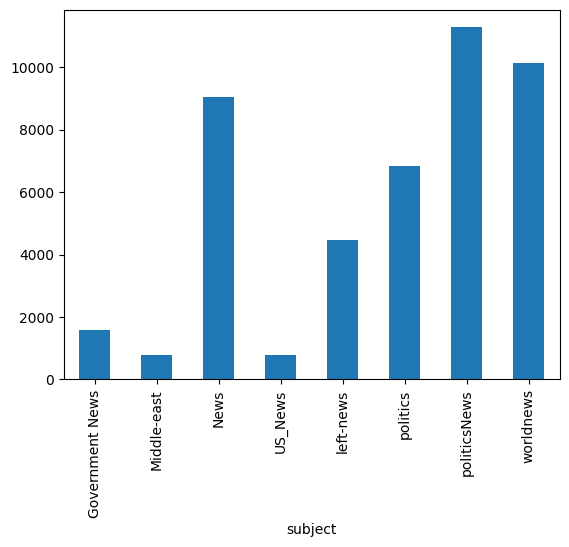

In [ ]:
# Basic data exploration
# Count articles per subject
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()



target
fake    23481
true    21417
Name: text, dtype: int64


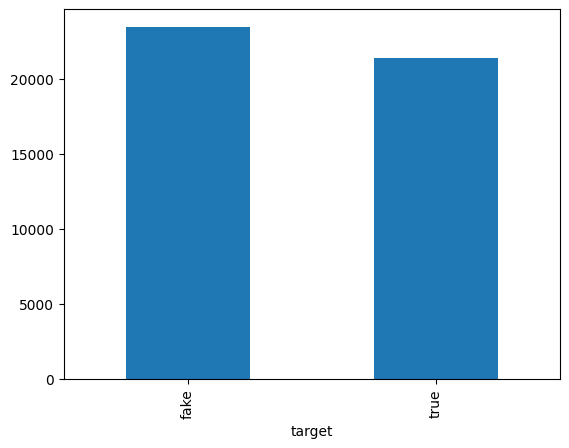

In [ ]:
# Count fake and real articles
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()



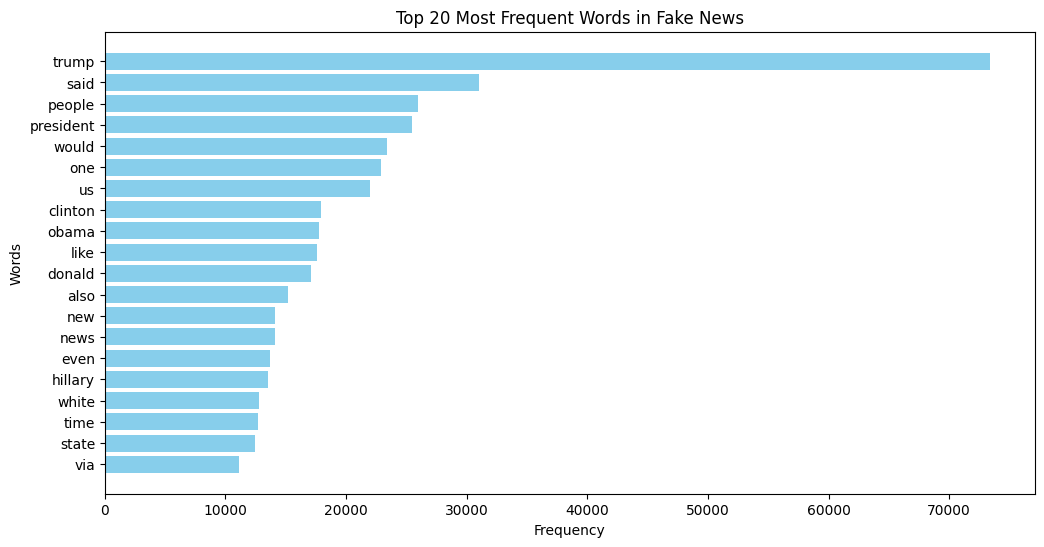

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

fake_data = data[data["target"] == "fake"]
all_words = ' '.join(fake_data.text).split()
word_counts = Counter(all_words).most_common(20)

words, counts = zip(*word_counts)
plt.figure(figsize=(12, 6))
plt.barh(words[::-1], counts[::-1], color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words in Fake News")
plt.show()


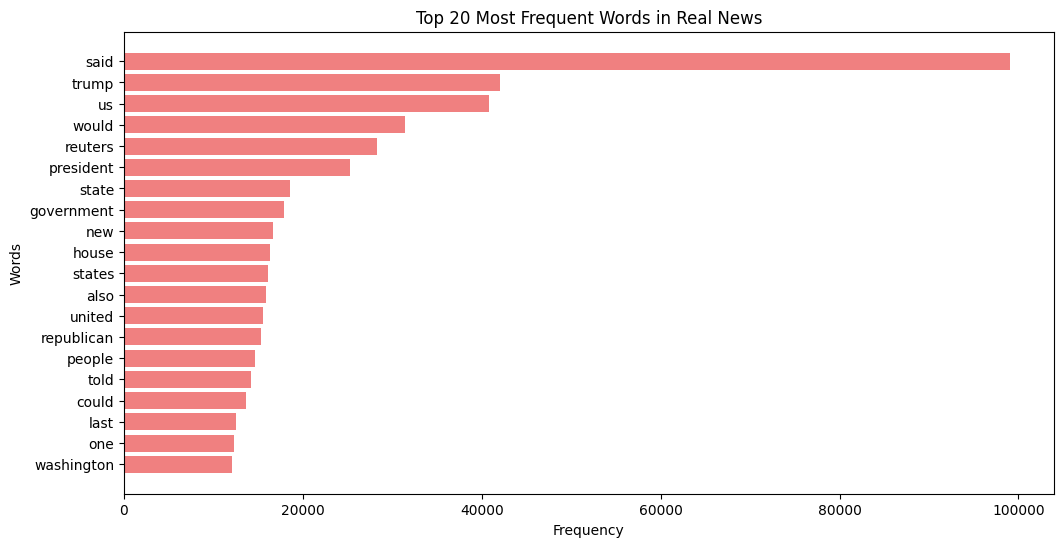

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

real_data = data[data["target"] == "true"]
all_words = ' '.join(real_data.text).split()
word_counts = Counter(all_words).most_common(20)

words, counts = zip(*word_counts)
plt.figure(figsize=(12, 6))
plt.barh(words[::-1], counts[::-1], color='lightcoral')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words in Real News")
plt.show()


In [ ]:
# Most frequent words counter function
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_frequency, x="Word", y="Frequency", color='blue')
    ax.set(ylabel="Count")
    plt.xticks(rotation='vertical')
    plt.show()



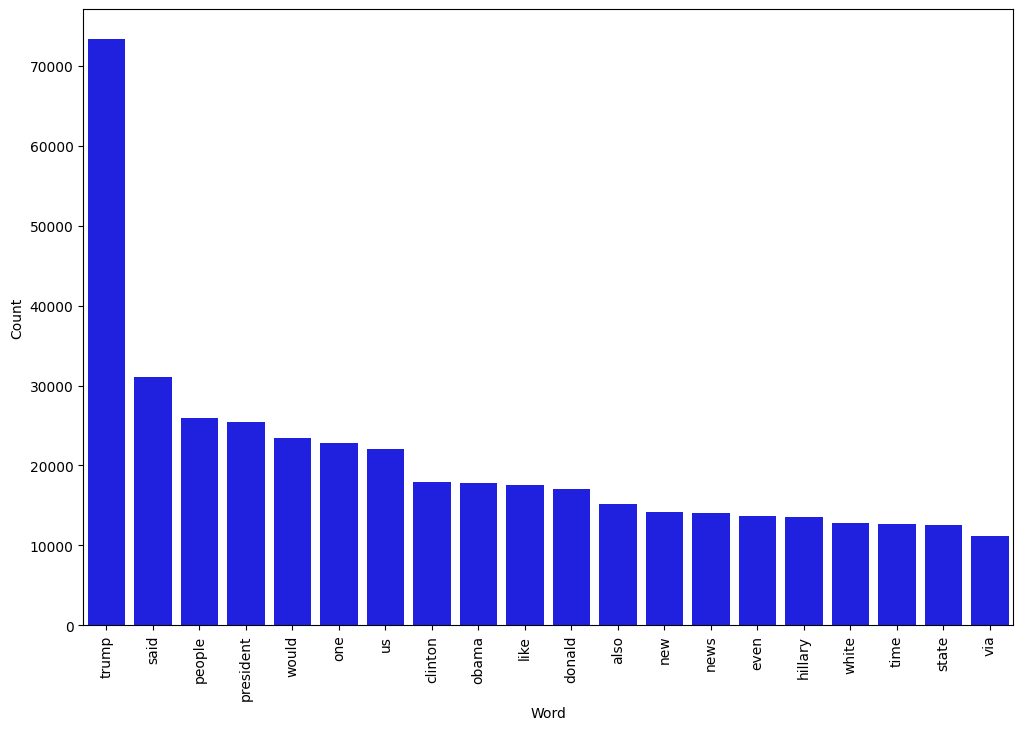

In [ ]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)



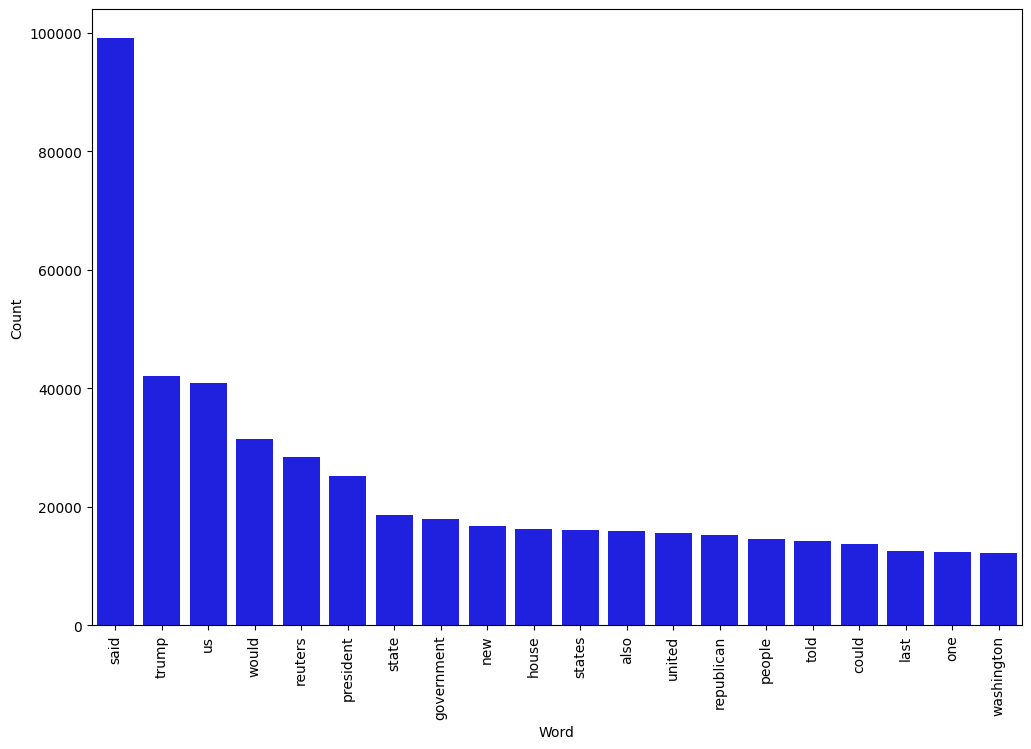

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)



In [ ]:
# Model preparation and training
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Naive Bayes accuracy: 95.18%
Confusion matrix, without normalization


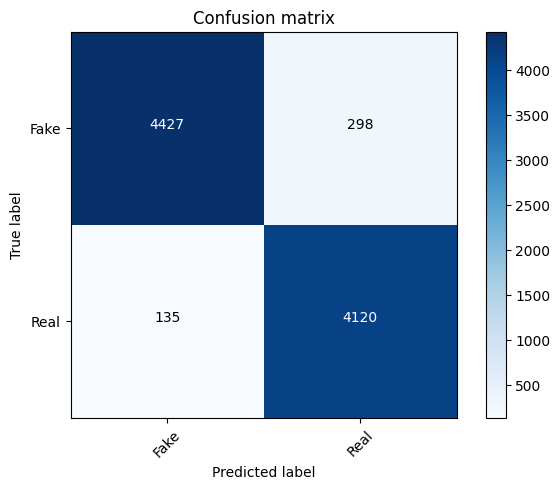

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# Naive Bayes model
NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', NB_classifier)])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("Naive Bayes accuracy: {}%".format(round(accuracy_score(y_test, prediction) * 100, 2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])



Logistic Regression accuracy: 98.86%
Confusion matrix, without normalization


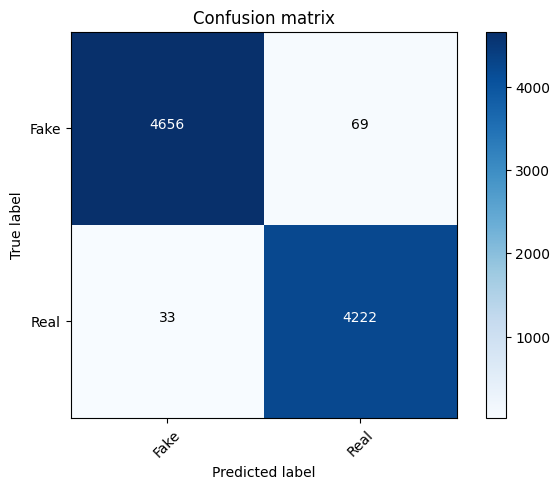

In [ ]:
# Logistic Regression model
pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LogisticRegression())])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("Logistic Regression accuracy: {}%".format(round(accuracy_score(y_test, prediction) * 100, 2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])



Decision Tree accuracy: 99.71%
Confusion matrix, without normalization


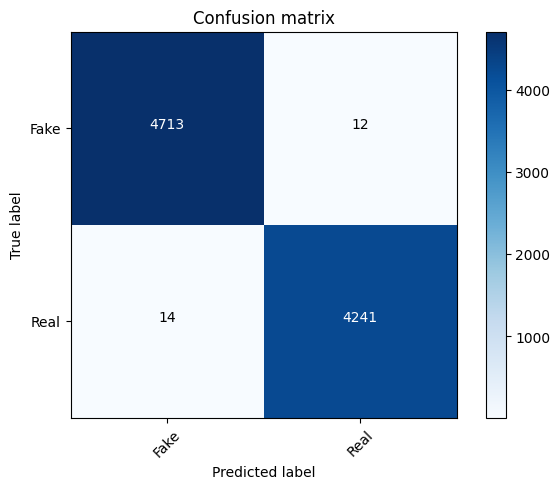

In [ ]:
# Decision Tree model
pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("Decision Tree accuracy: {}%".format(round(accuracy_score(y_test, prediction) * 100, 2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])



Random Forest accuracy: 99.11%
Confusion matrix, without normalization


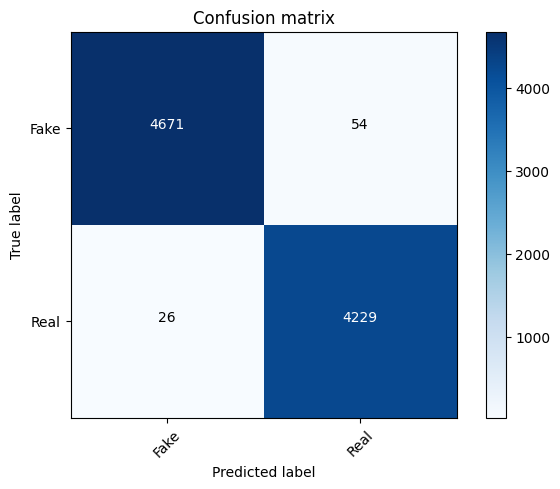

In [ ]:
# Random Forest model
pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("Random Forest accuracy: {}%".format(round(accuracy_score(y_test, prediction) * 100, 2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])



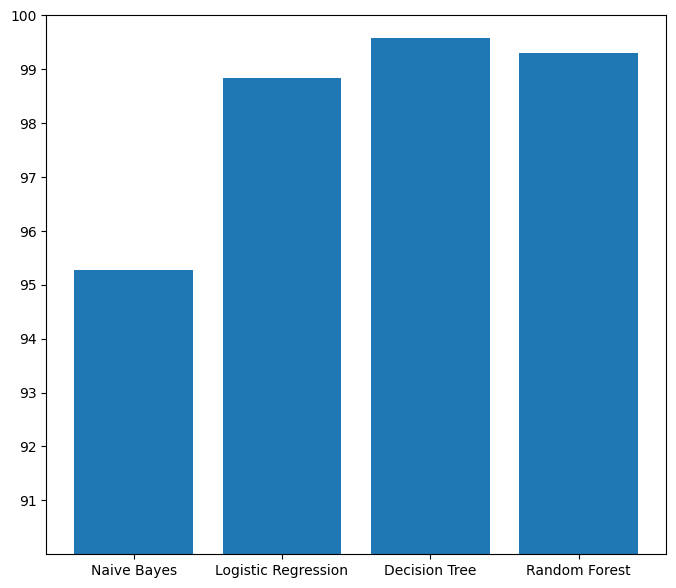

In [ ]:


# Comparing Different Models' accuracies
dct = {'Naive Bayes': 95.27, 'Logistic Regression': 98.84, 'Decision Tree': 99.58, 'Random Forest': 99.3}
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()), list(dct.values()))
plt.ylim(90, 100)
plt.yticks(np.arange(91, 101, 1))
plt.show()

In [ ]:
import requests

# Define the Hugging Face API function
def check_with_huggingface_api(text):
    api_url = "123456789"  # Replace with your API url
    api_key = "123456789"  # Replace with your API key
    payload = {
        "inputs": text,
        "parameters": {"candidate_labels": ["true", "false"]}
    }
    headers = {"Authorization": f"Bearer {api_key}"}

    try:
        response = requests.post(api_url, json=payload, headers=headers, timeout=5)
        if response.status_code == 200:
            result = response.json()
            top_label = result['labels'][0]
            print(f"API response for '{text}': {top_label} (scores: {result['scores']})")
            if top_label == "true":
                print("The text is classified as TRUE by the API.")
            else:
                print("The text is classified as FALSE by the API.")
            return top_label == "true"
        else:
            print(f"API error: {response.status_code} - Check your API key or network")
            return None
    except Exception as e:
        print(f"API request failed: {e}")
        return None



In [ ]:
# Function to classify text using the model
def classify_text(text, model):
    prediction = model.predict([text])[0]
    print(f"Model prediction for '{text}': {prediction}")

    # If the model predicts "fake", use Hugging Face API for rechecking
    if prediction == "fake":
        print("Model predicts fake. Checking with Hugging Face API...")
        api_result = check_with_huggingface_api(text)
        if api_result is not None:
            final_prediction = "True" if api_result else "False"
            print(f"API adjusted the prediction to: {final_prediction}")
            return final_prediction
        else:
            print("API failed, returning model prediction as fallback")
            return prediction
    else:
        print(f"Final prediction from model: {prediction}")
        return prediction




In [ ]:
# Interactive input for classification
while True:
    sentence = input("Enter a sentence to classify (type 'exit' to stop): ")
    if sentence.lower() == 'exit':
        break

    pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LogisticRegression())])
    model = pipe.fit(X_train, y_train)
    result = classify_text(sentence, model)
    print(f"Final Label: {result}\n")

Enter a sentence to classify (type 'exit' to stop): trump is dead
Model prediction for 'trump is dead': fake
Model predicts fake. Checking with Hugging Face API...
API response for 'trump is dead': false (scores: [0.5512239933013916, 0.448775976896286])
The text is classified as FALSE by the API.
API adjusted the prediction to: False
Final Label: False

Enter a sentence to classify (type 'exit' to stop): trump is alive
Model prediction for 'trump is alive': fake
Model predicts fake. Checking with Hugging Face API...
API response for 'trump is alive': true (scores: [0.9891647696495056, 0.010835287161171436])
The text is classified as TRUE by the API.
API adjusted the prediction to: True
Final Label: True

Enter a sentence to classify (type 'exit' to stop): Sunita Williams did not came back to earth
Model prediction for 'Sunita Williams did not came back to earth': fake
Model predicts fake. Checking with Hugging Face API...
API response for 'Sunita Williams did not came back to earth': f